In [3]:
#importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import tabulate
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter

In [3]:
#read data
data= pd.read_csv("G:\\My Drive\\Ryerson\\Capstone\\METABRIC_RNA_Mutation.csv\\METABRIC_RNA_Mutation.csv", sep=",")


C:\Users\mdaum\AppData\Local\Temp\ipykernel_13744\2593902994.py:2: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv("G:\\My Drive\\Ryerson\\Capstone\\METABRIC_RNA_Mutation.csv\\METABRIC_RNA_Mutation.csv", sep=",")


In [46]:
#seperating clinical attributes and converting into categorical variables
df_clinical =data.iloc[:, 1:31]
categorical_variables= ["type_of_breast_surgery","cancer_type","cancer_type_detailed","cellularity","chemotherapy","pam50_+_claudin-low_subtype","cohort","er_status_measured_by_ihc",
"er_status","neoplasm_histologic_grade","her2_status_measured_by_snp6","her2_status","tumor_other_histologic_subtype","hormone_therapy","inferred_menopausal_state","integrative_cluster",
"primary_tumor_laterality","oncotree_code","overall_survival","pr_status","radio_therapy","3-gene_classifier_subtype","tumor_stage","death_from_cancer"]
for i in categorical_variables:
    df_clinical[i] =df_clinical[i].astype("category")
print(df_clinical.dtypes)


age_at_diagnosis                   float64
type_of_breast_surgery            category
cancer_type                       category
cancer_type_detailed              category
cellularity                       category
chemotherapy                      category
pam50_+_claudin-low_subtype       category
cohort                            category
er_status_measured_by_ihc         category
er_status                         category
neoplasm_histologic_grade         category
her2_status_measured_by_snp6      category
her2_status                       category
tumor_other_histologic_subtype    category
hormone_therapy                   category
inferred_menopausal_state         category
integrative_cluster               category
primary_tumor_laterality          category
lymph_nodes_examined_positive      float64
mutation_count                     float64
nottingham_prognostic_index        float64
oncotree_code                     category
overall_survival_months            float64
overall_sur

Making a new datafraame for the treatments.

In [47]:
treatmentList = ["type_of_breast_surgery", "chemotherapy", "hormone_therapy", "radio_therapy"] 
dfTreatments = df_clinical[treatmentList].copy()  # Create a copy of the DataFrame

dfTreatments.loc[:, "type_of_breast_surgery"] = dfTreatments["type_of_breast_surgery"].apply(lambda x: 1 if "MASTECTOMY" in str(x) else 0)
dfTreatments.rename(columns={'type_of_breast_surgery': 'masectomy'}, inplace=True)
dfTreatments.head()

,masectomy,chemotherapy,hormone_therapy,radio_therapy
0,1,0,1,1
1,0,0,1,1
2,1,1,1,0
3,1,1,1,1
4,1,1,1,1


Dropping columns from the clinical df which are unnecessary and have low variability, and then concatenating with the treatment df

In [48]:
#seperating genetic data
df_genetic =data.iloc[:, 31:520]

In [49]:
col_to_remove =["type_of_breast_surgery", "cancer_type","cancer_type_detailed","chemotherapy","cohort","hormone_therapy","radio_therapy"]
df_clinical=df_clinical.drop(columns=col_to_remove)
df_for_treatment_prediction =pd.concat([df_clinical,dfTreatments,df_genetic],axis=1)
df_for_treatment_prediction.dtypes


age_at_diagnosis                float64
cellularity                    category
pam50_+_claudin-low_subtype    category
er_status_measured_by_ihc      category
er_status                      category
                                 ...   
tnk2                            float64
tulp4                           float64
ugt2b15                         float64
ugt2b17                         float64
ugt2b7                          float64
Length: 516, dtype: object

In [50]:
#encoding categogical data


categorical_variables= ["masectomy","cellularity","chemotherapy","pam50_+_claudin-low_subtype","er_status_measured_by_ihc",
"er_status","neoplasm_histologic_grade","her2_status_measured_by_snp6","her2_status","tumor_other_histologic_subtype","hormone_therapy","inferred_menopausal_state","integrative_cluster",
"primary_tumor_laterality","oncotree_code","overall_survival","pr_status","radio_therapy","3-gene_classifier_subtype","tumor_stage","death_from_cancer"]


label_encoder = LabelEncoder()
for i in categorical_variables:
    df_for_treatment_prediction[i] =label_encoder.fit_transform(df_for_treatment_prediction[i])

original_df_for_treatment_prdiction=df_for_treatment_prediction.copy(deep=True)
df_for_treatment_prediction =df_for_treatment_prediction.dropna(axis=0)



PCA for feature selection

In [51]:
#using PCA for feature selection


# Create a PCA object with the desired number of components
np.random.seed(42)
pca = PCA(n_components="mle",svd_solver="full",random_state=42)

# Perform PCA on the dataset
pca_for_treatment_prediction = pca.fit_transform(df_for_treatment_prediction)

# Access the explained variance ratio of each component
explained_variance = np.cumsum(pca.explained_variance_ratio_*100)
n_components=pca.n_components_
print(explained_variance)



[86.26548932 89.58858375 92.12567196 92.69380581 93.16223109 93.53745828
 93.80313947 94.04045826 94.25374924 94.42859958 94.57170435 94.71327469
 94.84245924 94.96095107 95.06821237 95.16180081 95.24722538 95.32847041
 95.40370877 95.4686744  95.5288229  95.58483262 95.63735813 95.68739843
 95.73550147 95.78083651 95.82508605 95.86839257 95.90953978 95.94958743
 95.98867101 96.02656571 96.06397575 96.10068324 96.13668657 96.17223371
 96.20582174 96.23904607 96.27199691 96.30391525 96.33521149 96.366328
 96.39667114 96.42686437 96.45558923 96.48407497 96.51242971 96.54016434
 96.56684688 96.59317876 96.61929483 96.64499644 96.67012181 96.69474874
 96.71899128 96.74273078 96.76619517 96.78958561 96.81238597 96.83482761
 96.85704109 96.87891268 96.90056246 96.92206204 96.94337578 96.9645974
 96.98556528 97.00608191 97.02644869 97.04668257 97.06668357 97.08640302
 97.10602172 97.12558402 97.14507506 97.16447553 97.18349279 97.20241757
 97.22125746 97.23995827 97.25852715 97.27696174 97.29

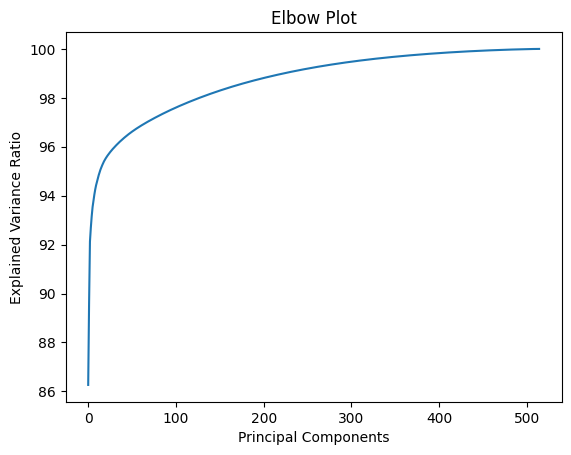

In [52]:
#plotting the variance to see choose the no of components

# Plot the explained variance ratio

plt.plot(explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot')
plt.show()

From the plot it seems almost 100% of the variability can be explained by 300 principal components. As a result we will use 300 components for future training.

Predicting the suitability of CHEMOTHERAPY as a treatment option. As Chemotherapy has imbalanced sampling, SMOTE and ROSE resampling techniques are used. And the results are compared.

In [53]:

#predicting chemotherapy using SMOTE .
# Load the dataset and split into features (X) and target variable (y)
X = df_for_treatment_prediction.drop(columns=['chemotherapy'])
y = df_for_treatment_prediction['chemotherapy']

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=300) 
X_pca = pca.fit_transform(scaled_X)



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Initialize d SMOTE resampling methods

smote = SMOTE()

# Apply the resampling method to the training set

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

print("Random Forest Classifier Cross-Validation Scores:")
print(rf_scores)
print("Mean Accuracy:", rf_scores.mean())

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_scores = cross_val_score(gb_classifier, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

print("Gradient Boosting Classifier Cross-Validation Scores:")
print(gb_scores)
print("Mean Accuracy:", gb_scores.mean())

# Train an SVM classifier
svm_classifier = SVC()
svm_scores = cross_val_score(svm_classifier, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

print("SVM Classifier Cross-Validation Scores:")
print(svm_scores)
print("Mean Accuracy:", svm_scores.mean())


Random Forest Classifier Cross-Validation Scores:
[0.91747573 0.87864078 0.9368932  0.98543689 0.99514563 0.99029126
 0.98543689 0.98543689 0.99512195 0.9902439 ]
Mean Accuracy: 0.9660123135211934
Gradient Boosting Classifier Cross-Validation Scores:
[0.86407767 0.83495146 0.89320388 0.90291262 0.91747573 0.94174757
 0.90776699 0.9368932  0.95609756 0.93170732]
Mean Accuracy: 0.9086834004262373
SVM Classifier Cross-Validation Scores:
[0.93203883 0.92718447 0.95145631 0.95145631 0.96116505 0.97572816
 0.95631068 0.95631068 0.9804878  0.96097561]
Mean Accuracy: 0.955311390007104


In [54]:
#predicting chemotherapy using ROSE
# Load the dataset and split into features (X) and target variable (y)
X = df_for_treatment_prediction.drop(columns=['chemotherapy'])
y = df_for_treatment_prediction['chemotherapy']

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=300) 
X_pca = pca.fit_transform(scaled_X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Initialize the ROSE  resampling method

RandomOverSampler = RandomOverSampler()

# Apply the resampling method to the training set

X_train_resampled, y_train_resampled = RandomOverSampler.fit_resample(X_train, y_train)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

print("Random Forest Classifier Cross-Validation Scores:")
print(rf_scores)
print("Mean Accuracy:", rf_scores.mean())

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_scores = cross_val_score(gb_classifier, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

print("Gradient Boosting Classifier Cross-Validation Scores:")
print(gb_scores)
print("Mean Accuracy:", gb_scores.mean())

# Train an SVM classifier
svm_classifier = SVC()
svm_scores = cross_val_score(svm_classifier, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

print("SVM Classifier Cross-Validation Scores:")
print(svm_scores)
print("Mean Accuracy:", svm_scores.mean())

Random Forest Classifier Cross-Validation Scores:
[0.97572816 0.97572816 1.         1.         0.99029126 0.99514563
 1.         1.         1.         0.99512195]
Mean Accuracy: 0.9932015155103006
Gradient Boosting Classifier Cross-Validation Scores:
[0.93203883 0.93203883 0.96601942 0.93203883 0.91747573 0.93203883
 0.94174757 0.94174757 0.93658537 0.92195122]
Mean Accuracy: 0.9353682216433816
SVM Classifier Cross-Validation Scores:
[0.94660194 0.9368932  0.95145631 0.94660194 0.92718447 0.96116505
 0.95145631 0.96601942 0.95121951 0.95121951]
Mean Accuracy: 0.9489817665166944


The ROSE algorithm gives slightly better accuracy

Predicting death_from_cancer

In [56]:
#scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_for_treatment_prediction)


X = df_for_treatment_prediction.drop(columns=['death_from_cancer'])
y = df_for_treatment_prediction['death_from_cancer']


pca = PCA(n_components=300) 
X_pca = pca.fit_transform(scaled_X)



# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

# Evaluation
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions, average='macro'))
print("Precision:", precision_score(y_test, rf_predictions, average='macro'))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))
print()

print("Gradient Boosting Classifier:")
print("Accuracy:", accuracy_score(y_test, gb_predictions))
print("Recall:", recall_score(y_test, gb_predictions, average='macro'))
print("Precision:", precision_score(y_test, gb_predictions, average='macro'))
print("Confusion Matrix:")
print(confusion_matrix(y_test, gb_predictions))
print()

print("Support Vector Machine (SVM) Classifier:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions, average='macro'))
print("Precision:", precision_score(y_test, svm_predictions, average='macro'))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))




Random Forest Classifier:
Accuracy: 0.6213768115942029
Recall: 0.41255251588370256
Precision: 0.40987104370769434
Confusion Matrix:
[[122  15  49   0]
 [ 49  13  71   0]
 [ 15   9 208   0]
 [  0   0   1   0]]

Gradient Boosting Classifier:
Accuracy: 0.7192028985507246
Recall: 0.508694915821255
Precision: 0.510356699751861
Confusion Matrix:
[[138  37  11   0]
 [ 46  55  32   0]
 [ 16  12 204   0]
 [  0   0   1   0]]

Support Vector Machine (SVM) Classifier:
Accuracy: 0.8242753623188406
Recall: 0.5965934197284088
Precision: 0.5956809249458476
Confusion Matrix:
[[140  44   2   0]
 [ 43  86   4   0]
 [  1   2 229   0]
 [  0   0   1   0]]


c:\Users\mdaum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mdaum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mdaum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting overall survival

In [57]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_for_treatment_prediction)

X = df_for_treatment_prediction.drop(columns=['overall_survival'])
y = df_for_treatment_prediction['overall_survival']

pca = PCA(n_components=300) 
X_pca = pca.fit_transform(scaled_X)



# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

# Evaluation
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions, average='macro'))
print("Precision:", precision_score(y_test, rf_predictions, average='macro'))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))
print()

print("Gradient Boosting Classifier:")
print("Accuracy:", accuracy_score(y_test, gb_predictions))
print("Recall:", recall_score(y_test, gb_predictions, average='macro'))
print("Precision:", precision_score(y_test, gb_predictions, average='macro'))
print("Confusion Matrix:")
print(confusion_matrix(y_test, gb_predictions))
print()

print("Support Vector Machine (SVM) Classifier:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Recall:", recall_score(y_test, svm_predictions, average='macro'))
print("Precision:", precision_score(y_test, svm_predictions, average='macro'))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))


Random Forest Classifier:
Accuracy: 0.7373188405797102
Recall: 0.6910560344827585
Precision: 0.8162753361428858
Confusion Matrix:
[[314   6]
 [139  93]]

Gradient Boosting Classifier:
Accuracy: 0.8786231884057971
Recall: 0.8668642241379311
Precision: 0.8844340621338942
Confusion Matrix:
[[301  19]
 [ 48 184]]

Support Vector Machine (SVM) Classifier:
Accuracy: 0.9873188405797102
Recall: 0.9866918103448276
Precision: 0.9872759639114779
Confusion Matrix:
[[317   3]
 [  4 228]]


Clustering the genetic data


In [58]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

X=df_for_treatment_prediction.iloc[:,27:].values # takeing only the genetic data
y=df_for_treatment_prediction["death_from_cancer"]


k = 4 # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0 )
kmeans.fit_predict(X)

from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(kmeans.labels_, y)
print("Adjusted Rand Index (ARI):", ari)


Adjusted Rand Index (ARI): 0.02056935376078903


c:\Users\mdaum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 As random labelings have an ARI close to 0.0. 1.0 stands for perfect match. It seems the clustering is random in regards to "death_from_cancer"

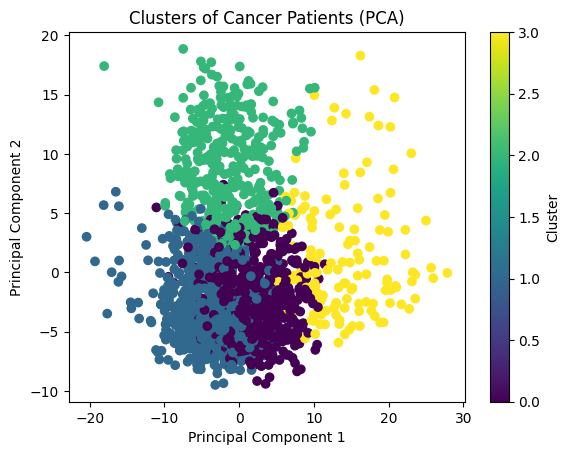

In [59]:
#plotting the clusters


# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting the scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters of Cancer Patients (PCA)')
plt.colorbar(label='Cluster')
plt.show()



Hierarchicalclustering of the genetic data

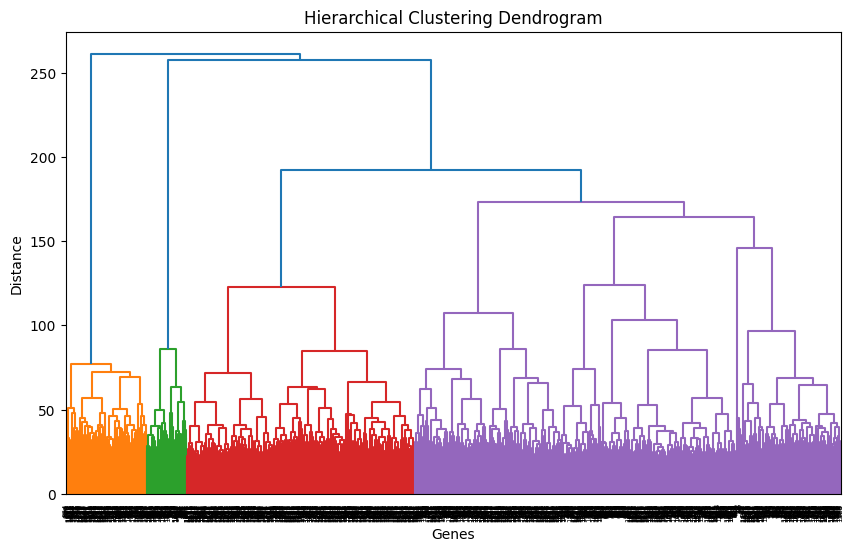

Adjusted Rand Index (ARI): 0.0038828343198253528


In [60]:


# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.xlabel('Genes')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


# Assign cluster labels based on the dendrogram
threshold = 50  # Adjust the threshold as needed
cluster_labels = fcluster(Z, t=threshold, criterion='distance')

# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)

Survival Analysis

In [61]:
#Creating a df for survival analysis
df_survival = pd.concat([df_clinical["overall_survival_months"],df_clinical["overall_survival"]],axis = 1)
df_survival.head

<bound method NDFrame.head of       overall_survival_months overall_survival
0                  140.500000                1
1                   84.633333                1
2                  163.700000                0
3                  164.933333                1
4                   41.366667                0
...                       ...              ...
1899               196.866667                1
1900                44.733333                0
1901               175.966667                0
1902                86.233333                0
1903               201.900000                0

[1904 rows x 2 columns]>

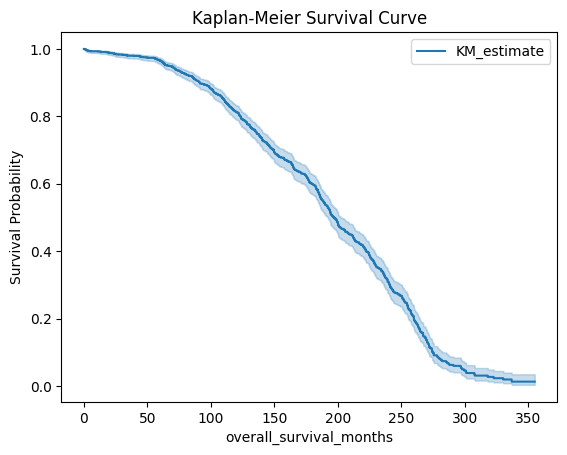

In [62]:
#plotting survival curve

kmf = KaplanMeierFitter()
kmf.fit(df_survival['overall_survival_months'], event_observed=df_survival['overall_survival'])

kmf.plot()
plt.xlabel('overall_survival_months')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve')
plt.show()

Text(0.5, 1.0, 'Survival Curve Based on Menopause')

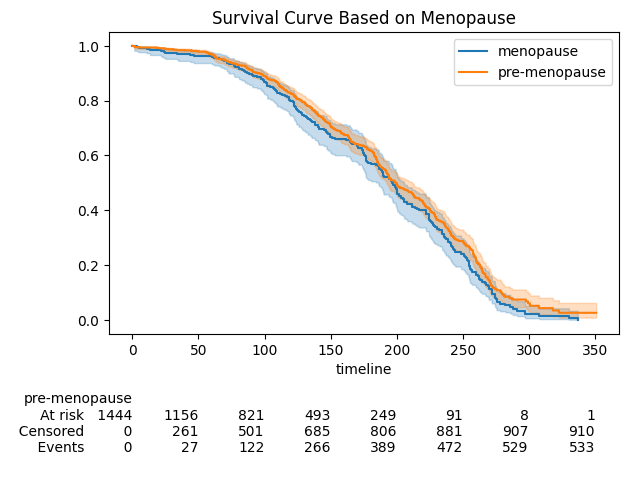

In [63]:
#evaluating the effect of menopause on overal survival
ax = plt.subplot(111)
menopause = (df_for_treatment_prediction["inferred_menopausal_state"] == 1)
kmf.fit(durations = df_for_treatment_prediction["overall_survival_months"][menopause], event_observed = df_for_treatment_prediction["overall_survival"][menopause], label = "menopause")
kmf.plot_survival_function(ax = ax)
kmf.fit(df_for_treatment_prediction["overall_survival_months"][~menopause], event_observed = df_for_treatment_prediction["overall_survival"][~menopause], label = "pre-menopause")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival Curve Based on Menopause")

it shows a litte bit more suvival probability in premenopausal women.

Text(0.5, 1.0, 'Survival Curve Based on her2 Satus')

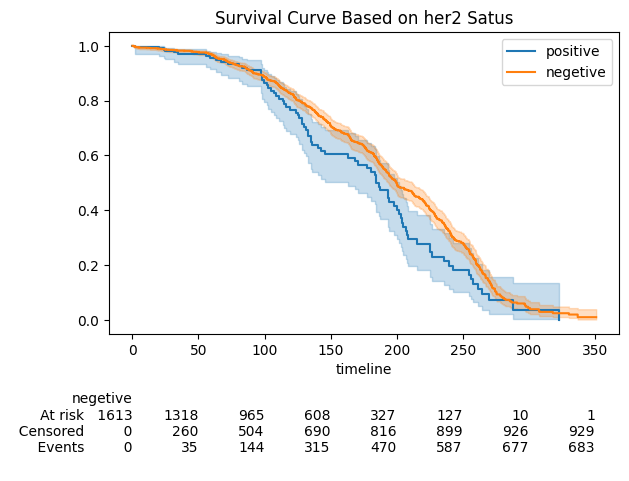

In [64]:
#evaluating effect of her2 status on survival

ax = plt.subplot(111)
positive = (df_for_treatment_prediction["her2_status"] == 1)
kmf.fit(durations = df_for_treatment_prediction["overall_survival_months"][positive], event_observed = df_for_treatment_prediction["overall_survival"][positive], label = "positive")
kmf.plot_survival_function(ax = ax)
kmf.fit(df_for_treatment_prediction["overall_survival_months"][~positive], event_observed = df_for_treatment_prediction["overall_survival"][~positive], label = "negetive")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival Curve Based on her2 Satus")

her2 negetive patients have a better probability of survival.

In [65]:

#finding out the median survival month
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_,median_confidence_interval_)


199.9666667      negetive_lower_0.95  negetive_upper_0.95
0.5           193.966667           211.733333


Survival Regression - Cox’s proportional hazard model


Cox model is a semi parametric model. The real advantage of Cox Proportional Hazards regression is that you can still fit survival models without knowing (or assuming) the distribution.

In [68]:


#encoding categorixal variables in the clinical df
new_survival_df =df_for_treatment_prediction.iloc[:, :27]


#cox model
cph = CoxPHFitter()
cph.fit(new_survival_df, duration_col='overall_survival_months', event_col='overall_survival')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1839 total observations, 1075 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'overall_survival'
      baseline estimation = breslow
   number of observations = 1839
number of events observed = 764
   partial log-likelihood = -4272.43
         time fit was run = 2023-06-22 20:17:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
age_at_diagnosis                 0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
cellularity                     -0.02       0.98       0.04            -0.10             0.06                 0.91                 1.06
pam50_+_claudin-low_subtype      0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
er_status_measured_by_ihc        0.04       1.05       0.15            -0.24             0.33                 0.79                 1.39
er_status                       -0.23       0.79       0.17            -0.56             0.09                 0.57                 1.10
neoplasm_histologic_grade       -0.14       0.87       0.06            -0.26            -0.01                 0.77                 0.99
her2_status_measured_by_snp6    -0.05       0.95       0.06            -0.18             0.07                 0.84                 1.08
her2_status                      0.18       1.20       0.17            -0.16             0.52                 0.86                 1.68
tumor_other_histologic_subtype  -0.01       0.99       0.03            -0.07             0.04                 0.93                 1.04
inferred_menopausal_state        0.30       1.35       0.13             0.05             0.56                 1.05                 1.75
integrative_cluster             -0.02       0.99       0.01            -0.04             0.01                 0.96                 1.01
primary_tumor_laterality         0.12       1.12       0.07            -0.02             0.25                 0.98                 1.28
lymph_nodes_examined_positive    0.01       1.01       0.02            -0.02             0.05                 0.98                 1.05
mutation_count                  -0.05       0.95       0.01            -0.08            -0.03                 0.93                 0.97
nottingham_prognostic_index     -0.11       0.90       0.06            -0.21             0.00                 0.81                 1.00
oncotree_code                   -0.00       1.00       0.04            -0.08             0.07                 0.92                 1.08
pr_status                       -0.09       0.91       0.10            -0.28             0.09                 0.75                 1.10
3-gene_classifier_subtype       -0.05       0.96       0.04            -0.12             0.03                 0.89                 1.03
tumor_size                       0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
tumor_stage                      0.09       1.09       0.03             0.03             0.14                 1.03                 1.15
death_from_cancer                3.07      21.60       0.19             2.70             3.44                14.94                31.23
masectomy                       -0.02       0.98       0.10            -0.22             0.17                 0.81                 1.19
chemotherapy                     0.55       1.73       0.13             0.30             0.79                 1.35                 2.21
hormone_therapy                  0.62       1.86       0.09             0.44             0.80                 1.56                 2.22
radio_therapy                    0.17       1.18       0.11            -0

<AxesSubplot: xlabel='log(HR) (95% CI)'>

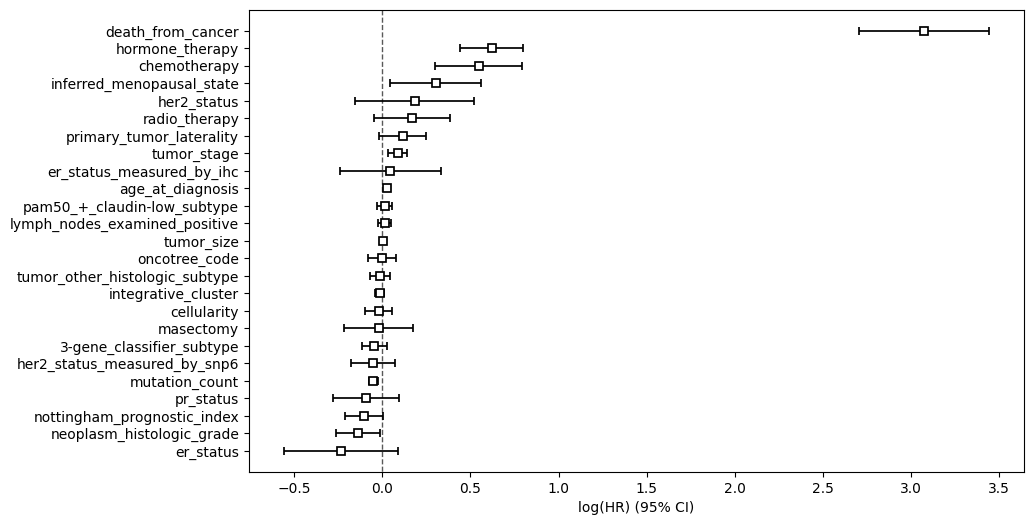

In [69]:
plt.subplots(figsize = (10, 6))
cph.plot()

<AxesSubplot: >

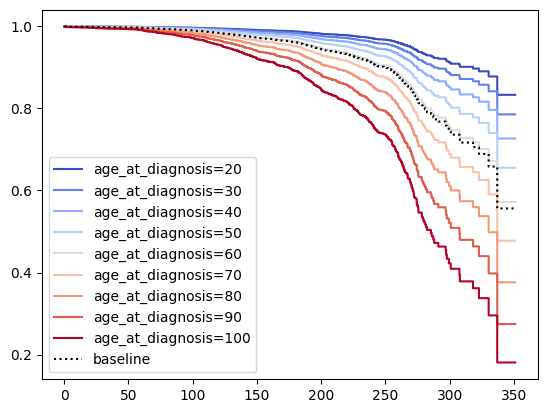

In [70]:
#effect of age at diagnosis on overall survival probability
cph.plot_partial_effects_on_outcome(covariates = 'age_at_diagnosis', values = [20,30,40,50, 60, 70, 80,90,100], cmap = 'coolwarm')

In [71]:
cph.check_assumptions(new_survival_df, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1839 total observations, 1075 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic      p  -log2(p)
3-gene_classifier_subtype      km              0.71   0.40      1.32
                               rank            1.15   0.28      1.81
age_at_diagnosis               km              0.05   0.82      0.29
                               rank            0.02   0.88      0.18
cellularity                    km              0.65   0.42      1.25
                               rank            0.41   0.52      0.93
chemotherapy                   km              0.70   0.40      1.31
                               rank            0.25   0.62      0.70
death_from_cancer              km              6.36   0.01      6.42
                               rank            6.61   0.01      6.62
er_status                      km              0.53   0.46      1.11
                               rank            0.66   0.42      1.26
er_status_measured_by_ihc      km              0.21   0.65      0.63
                               rank            0.51   0.48      1.07
her2_status                    km              0.31   0.58      0.79
                               rank            0.24   0.63      0.67
her2_status_measured_by_snp6   km              0.00   0.96      0.06
                               rank            0.00   0.98      0.04
hormone_therapy                km              0.02   0.88      0.18
                               rank            0.01   0.93      0.10
inferred_menopausal_state      km              0.10   0.75      0.42
                               rank            0.06   0.80      0.32
integrative_cluster            km              0.18   0.67      0.58
                               rank            0.29   0.59      0.77
lymph_nodes_examined_positive  km              0.38   0.54      0.89
                               rank            0.25   0.61      0.70
masectomy                      km              0.00   0.97      0.04
                               rank            0.02   0.89      0.17
mutation_count                 km              8.18 <0.005      7.88
                               rank            6.62   0.01      6.63
neoplasm_histologic_grade      km              0.55   0.46      1.12
                               rank            0.26   0.61      0.70
nottingham_prognostic_index    km              0.11   0.74      0.43
                               rank            0.10   0.76      0.40
oncotree_code                  km              1.30   0.25      1.97
                               rank            1.22   0.27      1.89
pam50_+_claudin-low_subtype    km              0.25   0.62      0.69
                               rank            0.06   0.80      0.32
pr_status                      km              0.22   0.64      0.64
                               rank            0.11   0.75      0.42
primary_tumor_laterality       km              0.52   0.47      1.08
                               rank            0.72   0.40      1.34
radio_therapy                  km              0.77   0.38      1.40
                               rank            0.70   0.40      1.31
tumor_other_histologic_subtype km              0.60   0.44      1.19
                               rank            0.65   0.42      1.25
tumor_size                     km              0.91   0.34      1.55
                               rank            0.62   0.43      1.21
tumor_stage                    km              3.84   0.05      4.32
                               rank            2.18   0.14      2.84



1. Variable 'mutation_count' failed the non-proportional test: p-value is 0.0042.

   Advice 1: the functional form of the variable 'mutation_count' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'mutation_count' using pd.cut, and then specify it in
`strata=['mutation_count', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'tumor_stage' failed the non-proportional test: p-value is 0.0500.

   Advice 1: the functional form of the variable 'tumor_stage' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below 

[]

In [5]:
#seperating mutation data
df_mutation =data.iloc[:,520:]